In [1]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_regression, chi2, VarianceThreshold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [2]:
'''
Class to be imported in pipeline (below) for dropping the most correlated columns, preventing data leakage.
'''

class MyDecorrelator(BaseEstimator, TransformerMixin): 
    
    def __init__(self, threshold):
        self.threshold = threshold
        self.correlated_columns = None

    def fit(self, X, y=None):
        correlated_features = set()  
        X = pd.DataFrame(X)
        corr_matrix = X.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > self.threshold: # we are interested in absolute coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    correlated_features.add(colname)
        #print(np.shape(pd.DataFrame(X).drop(labels=correlated_features, axis=1)))
        #print(pd.DataFrame(X).drop(labels=correlated_features, axis=1))
        self.correlated_features = correlated_features
        return self

    def transform(self, X, y=None, **kwargs):
        return (pd.DataFrame(X)).drop(labels=self.correlated_features, axis=1)

In [3]:
Data_complete = pd.read_excel(r'Data_Henry_CO2.xlsx', index_col = 0)  #Import Dataset

In [5]:
#Replace the the property of interest (spanning many orders of magnitude) with its log
Data_complete['henry_coefficient_CO2_298K [mol/kg/bar]'] = np.log(Data_complete['henry_coefficient_CO2_298K [mol/kg/bar]'])

In [43]:
Data_complete.iloc[6000]

jml_bp_mult_atom_rad                       1617.494800
jml_hfus_add_bp                            1633.848150
jml_elec_aff_mult_voro_coord                  3.260200
jml_mol_vol_subs_atom_mass                   -7.607248
jml_is_halogen                                0.000000
                                              ...     
jml_nn_97                                     5.680556
jml_nn_98                                     5.722222
jml_nn_99                                     4.333333
jml_nn_100                                    5.875000
henry_coefficient_CO2_298K [mol/kg/bar]      11.056239
Name: str_m5_o16_o17_sra_sym.67.cif, Length: 1558, dtype: float64

In [7]:
train_df, test_df = train_test_split(Data_complete, test_size=0.2, random_state=0)

In [8]:
rf = RandomForestRegressor(random_state=0)

pipe = Pipeline([
        ('threshold', VarianceThreshold(threshold = 0)),         #Drop features with no variance
        ('decorrelation', MyDecorrelator(0.9)),                  #Drop features with correlation above 0.9
        ('feature_selector', SelectPercentile(f_regression)),    #Select features in terms of the most relevant for f_regression
        ('rf', rf)                                               #Train Random Forest 
        ], verbose = 1)

In [9]:
param_grid = {
    "rf__n_estimators": [100, 200, 500, 1000],                    #Tune the number of estimators
    "rf__max_features": ['auto', 'sqrt', 'log2'],                 #Tune the number of features to consider when looking for the best split
    "feature_selector__percentile": [25, 50, 75, 100]             #Tune the percentage of features to retain in terms of f_regression score
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose = 1, cv = 5)

In [10]:
search.fit(train_df.iloc[:, :-1], train_df.iloc[:, -1])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 115.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 160.8min finished


[Pipeline] ......... (step 1 of 4) Processing threshold, total=   0.2s
[Pipeline] ..... (step 2 of 4) Processing decorrelation, total= 1.2min
[Pipeline] .. (step 3 of 4) Processing feature_selector, total=   0.0s
[Pipeline] ................ (step 4 of 4) Processing rf, total= 8.6min


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('threshold',
                                        VarianceThreshold(threshold=0)),
                                       ('decorrelation',
                                        MyDecorrelator(threshold=0.9)),
                                       ('feature_selector',
                                        SelectPercentile(percentile=10,
                                                         score_func=<function f_regression at 0x000002684098B8B8>)),
                                       ('rf',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_d...
                                                              n_

In [11]:
search.best_params_

{'feature_selector__percentile': 100,
 'rf__max_features': 'auto',
 'rf__n_estimators': 500}

In [12]:
test_predictions = search.predict(test_df.iloc[:, :-1])
test_labels = test_df.iloc[:, -1].values

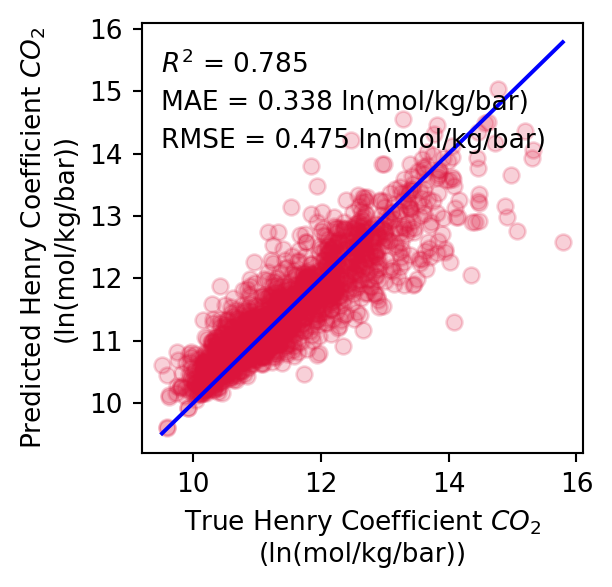

In [28]:


r2 = sklearn.metrics.r2_score(test_labels, test_predictions)
mae = mean_absolute_error(test_labels, test_predictions)
rmse = np.sqrt(mean_squared_error(test_labels, test_predictions))

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3), dpi = 190)
plt.scatter(test_labels, test_predictions, c='crimson', alpha = 0.2)
p1 = max(max(test_predictions), max(test_labels))
p2 = min(min(test_predictions), min(test_labels))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.rc('xtick', labelsize=15)
#plt.rc('ytick', labelsize = 15)
plt.annotate('$R^2$ = %0.3f' % r2, xy=(12, 15), xytext=(9.5, 15.3),
            )
plt.annotate('MAE = %0.3f ln(mol/kg/bar)' % mae, xy=(9.3, 15), xytext=(9.5, 14.7),
         )
plt.annotate('RMSE = %0.3f ln(mol/kg/bar)' % rmse, xy=(9.3, 14.5), xytext=(9.5, 14.1),
            )
plt.xlabel('True Henry Coefficient $CO_2$\n(ln(mol/kg/bar))')#, fontsize = 15)
plt.ylabel('Predicted Henry Coefficient $CO_2$\n(ln(mol/kg/bar))')#, fontsize = 15
plt.show()

In [44]:
from joblib import dump, load
dump(search, 'Henry_CO2_model.joblib') 

['Henry_CO2_model.joblib']

# Manual Refit
We manually refit the best pipeline over the all training set, in order to isolate the model and to compute the SHAP values with the TreeExplainer over the entire testing set. Otherwise, the pipeline would be seen as a black box by SHAP, and we would be compelled to use the agnostic KernelSHAP interpretation algorithm.

In [29]:
X_train = train_df.iloc[:, :-1].loc[:, VarianceThreshold(threshold = 0).fit(train_df.iloc[:, :-1]).get_support()]
X_test = test_df[X_train.columns]

In [30]:
correlated_features = set()  
corr_matrix = X_train.iloc[:, :-1].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9: # we are interested in absolute coeff value
            colname = corr_matrix.columns[i]  # getting the name of column
            correlated_features.add(colname)

In [31]:
X_train = X_train.drop(labels=correlated_features, axis=1)
X_test = X_test[X_train.columns]
y_train = train_df.iloc[:, -1]
y_test = test_df.iloc[:, -1]

In [32]:
X_train = X_train.loc[:, SelectPercentile(f_regression, percentile = 100).fit(X_train, y_train).get_support()]
X_test = X_test[X_train.columns]

In [34]:
rf = RandomForestRegressor(random_state=0, n_estimators = 500, max_features = 'auto')
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [36]:
y_predictions = rf.predict(X_test)

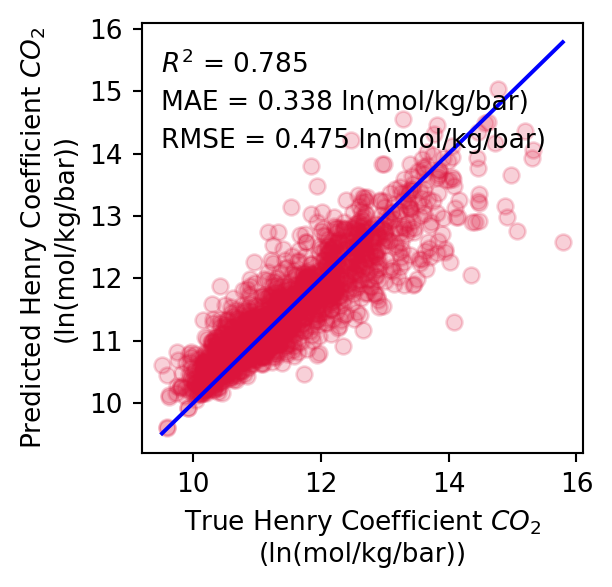

In [37]:
r2 = sklearn.metrics.r2_score(y_test, y_predictions)
mae = mean_absolute_error(y_test, y_predictions)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions))

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3), dpi = 190)
plt.scatter(test_labels, test_predictions, c='crimson', alpha = 0.2)
p1 = max(max(y_predictions), max(y_test))
p2 = min(min(y_predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
#plt.rc('xtick', labelsize=15)
#plt.rc('ytick', labelsize = 15)
plt.annotate('$R^2$ = %0.3f' % r2, xy=(12, 15), xytext=(9.5, 15.3),
            )
plt.annotate('MAE = %0.3f ln(mol/kg/bar)' % mae, xy=(9.3, 15), xytext=(9.5, 14.7),
         )
plt.annotate('RMSE = %0.3f ln(mol/kg/bar)' % rmse, xy=(9.3, 14.5), xytext=(9.5, 14.1),
            )
plt.xlabel('True Henry Coefficient $CO_2$\n(ln(mol/kg/bar))')#, fontsize = 15)
plt.ylabel('Predicted Henry Coefficient $CO_2$\n(ln(mol/kg/bar))')#, fontsize = 15
plt.show()

In [38]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

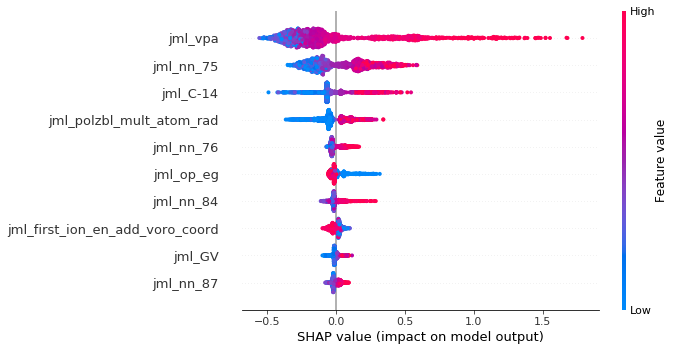

In [39]:
shap.summary_plot(shap_values, X_test, max_display = 10)

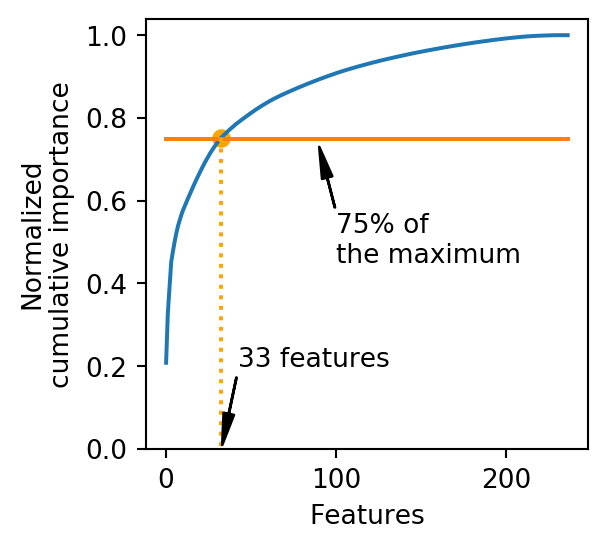

In [41]:
N = np.shape(X_test)[1]
k = 0.75
import matplotlib.pyplot as plt
cumsum = np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])
normalized_cumulative = np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])/(np.max(np.cumsum(np.sort(np.mean(abs(shap_values), axis = 0))[::-1])))

                                                                                       
fig, ax = plt.subplots(figsize=(3, 3), dpi = 190)
ax.plot(np.arange(N), normalized_cumulative)
ax.plot(np.arange(N), k*np.ones(N))
ind_cross1 = np.argmin(np.fabs(normalized_cumulative-k*max(normalized_cumulative)*np.ones(N)))
#plt.yticks(np.array([0, 0.5, 1]))

ax.annotate('%i features' %(ind_cross1+1), xy=(ind_cross1+1, .01), xytext=(ind_cross1+10,.2),
            arrowprops=dict(facecolor='black', shrink=0.000005, width = .1, headwidth=4),
            )
ax.annotate('75% of\nthe maximum', xy=(90, 0.73), xytext=(100, 0.45),
            arrowprops=dict(facecolor='black', shrink=0.0005, width = .1, headwidth=4),
            )
plt.scatter(ind_cross1, normalized_cumulative[ind_cross1], color = 'orange')
plt.plot((ind_cross1, ind_cross1), (normalized_cumulative[ind_cross1], 0), color = 'orange', ls = ':')
plt.ylim(0, 1.04)
plt.xlabel('Features')
plt.ylabel('Normalized\ncumulative importance')
plt.show()

In [45]:
X_test

,jml_bp_mult_atom_rad,jml_elec_aff_mult_voro_coord,jml_mol_vol_subs_atom_mass,jml_is_halogen,jml_voro_coord_divi_therm_cond,jml_polzbl_mult_atom_rad,jml_GV,jml_voro_coord_subs_therm_cond,jml_C-4,jml_elec_aff_subs_first_ion_en,...,jml_nn_91,jml_nn_92,jml_nn_93,jml_nn_94,jml_nn_95,jml_nn_96,jml_nn_97,jml_nn_98,jml_nn_99,jml_nn_100
MOFname,,,,,,,,,,,,,,,,,,,,,
str_m7_o4_o9_bcu_sym.219.cif,1484.1148,4.93620,-9.503628,0.0,49.156926,2.342380,62.95740,-41.446582,-0.28,-11.156739,...,5.700000,5.842857,6.514286,5.671429,5.885714,6.357143,6.457143,7.742857,6.171429,7.542857
str_m3_o41_o41_fof_sym.15.cif,980.2600,4.99820,-13.852008,0.2,115.806056,2.369880,54.59060,-47.443196,-0.28,-10.734324,...,4.086420,4.728395,4.913580,4.234568,4.666667,4.962963,5.209877,5.000000,5.074074,5.246914
str_m5_o11_o13_sra_sym.112.cif,2009.2975,4.02275,-9.392385,0.0,32.457831,4.639225,63.49175,-38.051770,-0.35,-10.259996,...,6.050847,5.779661,6.932203,5.745763,6.932203,6.457627,7.864407,6.711864,6.355932,6.779661
str_m3_o1_o4_pcu_sym.46.cif,942.4948,2.24820,-10.332748,0.0,49.147219,2.076880,53.31200,-47.646582,-0.28,-11.731618,...,7.078947,7.552632,6.657895,7.973684,6.157895,6.684211,7.157895,6.473684,9.763158,8.657895
str_m5_o16_o25_sra_sym.41.cif,1617.4948,3.26020,-7.607248,0.0,49.195069,3.854380,51.14140,-29.846582,-0.28,-11.100817,...,4.960526,5.013158,5.710526,5.763158,6.513158,6.118421,5.605263,6.644737,6.105263,5.881579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
str_m2_o5_o29_pcu_sym.58.cif,1487.8948,5.08980,-10.370148,0.0,49.136553,2.166880,56.39740,-103.246582,-0.28,-11.161255,...,5.068182,6.795455,5.318182,4.954545,5.227273,4.727273,5.318182,5.136364,6.068182,6.295455
str_m7_o9_o24_bcu_sym.66.cif,1841.6135,5.11275,-12.219685,0.0,33.229453,2.807675,76.67500,-52.551583,0.00,-10.893911,...,6.616279,6.511628,6.976744,7.511628,7.686047,7.418605,7.639535,8.011628,7.697674,7.686047
str_m4_o4_o15_acs_sym.102.cif,1448.2148,3.53420,-8.036168,0.0,49.151829,3.754380,70.39340,-42.446582,-0.28,-11.077481,...,7.264286,6.907143,7.557143,7.200000,7.264286,7.364286,7.992857,8.664286,9.085714,9.150000


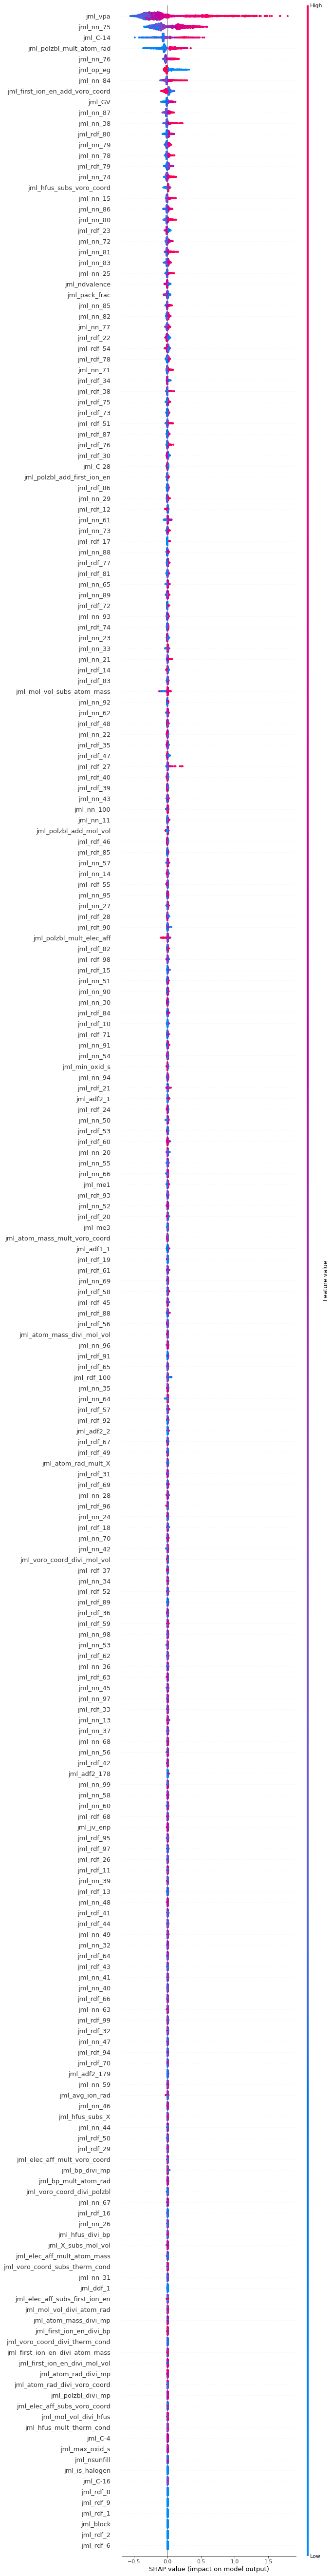

In [46]:
shap.summary_plot(shap_values, X_test, max_display = 237)

In [51]:
Output_shap = pd.DataFrame(shap_values, index = X_test.index, columns = X_test.columns)

In [52]:
Output_shap_mean = pd.DataFrame(abs(Output_shap).describe().loc['mean']/sum(abs(Output_shap).describe().loc['mean'])).sort_values('mean', ascending = False)

In [53]:
Output_shap_mean.to_excel('Output_mean_shap_Henry_CO2.xlsx')

In [56]:
Output_shap.to_excel('Output_shap_Henry_CO2.xlsx')